#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of handwritten digits (MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## 1) Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [ ]:
#!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
#!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

How to load the data:

In [ ]:
train_df = pd.read_csv('regression_dataset/train_data.csv')

How to get a specific sample:

In [ ]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

All training points:

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

---

**Dataset**
- Download the data in local directory
- Load the data
- Create test set
- Explore the data
- Prepare the dataset
  - Define the dataset
  - Transformations
    - Data Cleaning (not neccessary)
    - Feautre selection (not neccessary)
    - Feature Scaling ?????
  - Initialize the dataset
  - Define the dataloaders
 
**Models**
 - Model 1: basic
 - Model 2: L2, dropout

**Training**
 - Train method
 - Test method
 
**Hyperparameters tuning:**
 - Basic with K-fold
 - grid-search with K-fold
 - Plot loss
 
**Test the model**
 
**Metrics summary:**
  - Loss, Bias & variance
  
**Save the model:**
 - ...

**Network Analysis:**
  - Weights histogram
  - Analyze activations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

## 1) Dataset

### 1.1) Dataset object

In [2]:
class Dataset(Dataset):

    def __init__(self, data, transform=None):
        """
        Args:
            data (numpy array): numpy array
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform

        self.data = data
            

        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

### 1.2) Transformations

In [3]:
class ToTensor(object):
    """Convert sample to Tensors."""
    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor([x]).float(),
            torch.Tensor([y]).float())

### 1.3) Load and initialize Dataset

In [4]:
#Load from CSV
train_df = pd.read_csv('regression_dataset/train_data.csv').values
test_df = pd.read_csv('regression_dataset/test_data.csv').values

#Split Full dataset in Train and Validation
train_dataset = train_df[:int(len(train_df)*0.8)]
val_dataset = train_df[int(len(train_df)*0.8):]


composed_transform = transforms.Compose([ToTensor()])

train_dataset = Dataset(train_dataset, transform=composed_transform)
val_dataset   = Dataset(val_dataset, transform=composed_transform)
test_dataset  = Dataset(test_df, transform=composed_transform)


"""
from sklearn.model_selection import train_test_split

train, val = train_test_split("full.csv", test_size=0.2)

"""

'\nfrom sklearn.model_selection import train_test_split\n\ntrain, val = train_test_split("full.csv", test_size=0.2)\n\n'

In [ ]:
#Dataloaers
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, num_workers=0)

## 2) Models

In [5]:
class BasicRegNet(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.sig = nn.Sigmoid()
        self.relu= nn.ReLU()
        
        self.name="BasicRegNet"

        print('Network initialized')
        
    def forward(self, x, additional_out=False):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)
        return x

In [ ]:
class BasicRegNet(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.sig = nn.Sigmoid()
        self.relu= nn.ReLU()
        
        self.name="BasicRegNet"

        print('Network initialized')
        
    def forward(self, x, additional_out=False):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)
        return x

## 3) Training

In [6]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [7]:
# Initialize the network and move the parameters to the proper device

torch.manual_seed(0)

Ni = 1
Nh1 = 32
Nh2 = 32
No = 1

net=BasicRegNet(Ni,Nh1,Nh2,No)

net.to(device)
print(net)

Network initialized
BasicRegNet(
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (sig): Sigmoid()
  (relu): ReLU()
)


In [8]:
# Define the loss function
loss_function = nn.MSELoss()

In [ ]:
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
def train(net, num_epochs=100, verbose=False,early_stopping=None):
    #Print informations on the training
    if verbose: print(f"Training for {num_epochs}, Early stopping={early_stopping}")
    
    train_loss_log = []
    val_loss_log = []
    best_val,index_best=float("inf"),-1
    for epoch_num in range(num_epochs):

        ### TRAIN
        train_loss= []
        net.train() # Training mode (e.g. enable dropout)
        for sample_batched in train_dataloader:

            # Move data to device
            x_batch=sample_batched[0].to(device)
            label_batch=sample_batched[1].to(device)

            # Forward pass
            out=net(x_batch)

            # Compute loss
            loss=loss_function(out,label_batch)

            # Backpropagation
            net.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

        # Save average train loss
        train_loss = np.mean(train_loss)
        train_loss_log.append(train_loss)


        ### VALIDATION
        val_loss= []
        net.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_dataloader:
                
                # Move data to device
                x_batch=sample_batched[0].to(device)
                label_batch=sample_batched[1].to(device)

                # Forward pass
                out=net(x_batch)

                # Compute loss
                loss=loss_function(out,label_batch)

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

            # Save average validation loss
            val_loss = np.mean(val_loss)
            val_loss_log.append(val_loss)

        #Print Epoch informations
        if verbose: print(f"Epoch: {epoch_num+1}/{num_epochs}\tTrain Loss: {str(round(train_loss,3))}\tVal Loss:{str(round(val_loss,3))}")
        
        if val_loss<=best_val:
            best_val=val_loss
            index_best=epoch_num
        
        #Early Stopping
        if early_stopping:
            if index_best<epoch_num-early_stopping:
                if verbose: print("Early Stopped")
                break
    return (train_loss_log,val_loss_log)

In [ ]:
#Train
train_loss_log,val_loss_log=train(net,num_epochs=2000, verbose=True)

In [ ]:
import datetime
save_name=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+"_"+net.name

# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig("models/"+save_name+"_Losses", dpi=400)
plt.show()

## 4) Test the model

In [ ]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = net(x_batch)
        # Save outputs and labels
        all_inputs.append(x_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_function(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

## 5) Metrics Summary

In [ ]:
#Train Loss
train_loss=train_loss_log[-1]

#Val loss
val_loss=val_loss_log[-1]

print("Train Loss:\t",round(train_loss,3))
print("Val Loss:\t",round(val_loss,3))
print("Test Loss:\t",round(float(test_loss),3))

## 6) Save model

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
# Save the state dict to a file
torch.save(net_state_dict, "models/"+save_name+".torch")

#Save Metrics to File
f = open("models/"+save_name+"_Metrics.txt", "a")
f.write('Train loss:\t'+ str(round(train_loss,3))+ "\n")
f.write('Train loss:\t'+ str(round(val_loss,3))+ "\n")
f.write('Train loss:\t'+ str(round(float(test_loss),3))+ "\n")
f.close()

---
---
---
---
---
---
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## 1) Dataset

In [46]:
#Load from CSV
train_dataset = pd.read_csv('regression_dataset/train_data.csv').values
test_dataset = pd.read_csv('regression_dataset/test_data.csv').values

#Prepare X_train, y_train, X_test, y_test
X_train=train_dataset[:,0]
y_train=train_dataset[:,1]

X_test=test_dataset[:,0]
y_test=test_dataset[:,1]

#convert to Pytorch tensor
X_train=np.expand_dims(X_train, axis=1)
y_train=np.expand_dims(y_train, axis=1)
X_train=torch.from_numpy(X_train).float()
y_train=torch.from_numpy(y_train).float()

X_test=np.expand_dims(X_test, axis=1)
y_test=np.expand_dims(y_test, axis=1)
X_test=torch.from_numpy(X_test).float()
y_test=torch.from_numpy(y_test).float()

## 2) Models

In [ ]:
class BasicRegNet(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.sig = nn.Sigmoid()
        self.relu= nn.ReLU()
        
        self.name="BasicRegNet"

        print('Network initialized')
        
    def forward(self, x, additional_out=False):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)
        return x

## 3) Training

In [47]:
from skorch import NeuralNetRegressor

net = NeuralNetRegressor(
    module=BasicRegNet,
    module__Ni= 1,
    module__Nh1 = 32,
    module__Nh2 = 32,
    module__No = 1,
    max_epochs=2000,
    
    device=device,  # uncomment this to train with CUDA
    optimizer = torch.optim.Adam,
    optimizer__lr=0.001,
    #criterion=nn.MSELoss() #used by default
)

net.fit(X_train, y_train)

(100, 2)
torch.Size([100, 1]) torch.Size([100, 1])
<class 'torch.Tensor'>
Network initialized
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       16.2585        5.6360  0.0050
      2       15.9600        5.5212  0.0060
      3       15.6815        5.4119  0.0060
      4       15.4132        5.3078  0.0050
      5       15.1514        5.2051  0.0050
      6       14.8966        5.1158  0.0050
      7       14.6472        5.0373  0.0050
      8       14.4033        4.9675  0.0050
      9       14.1677        4.9037  0.0060
     10       13.9474        4.8431  0.0070
     11       13.7301        4.7855  0.0060
     12       13.5155        4.7319  0.0060
     13       13.3037        4.6821  0.0060
     14       13.0948        4.6392  0.0050
     15       12.8897        4.6015  0.0050
     16       12.6868        4.5614  0.0050
     17       12.4879        4.5182  0.0080
     18       12.2956        4.4829  0.0070
     19       12.1061     

    147        1.7608        4.5728  0.0040
    148        1.7564        4.5555  0.0070
    149        1.7520        4.5381  0.0060
    150        1.7477        4.5209  0.0060
    151        1.7434        4.5038  0.0060
    152        1.7391        4.4868  0.0050
    153        1.7349        4.4700  0.0060
    154        1.7307        4.4535  0.0060
    155        1.7266        4.4373  0.0050
    156        1.7225        4.4219  0.0050
    157        1.7185        4.4074  0.0050
    158        1.7145        4.3935  0.0060
    159        1.7105        4.3801  0.0050
    160        1.7066        4.3672  0.0050
    161        1.7028        4.3545  0.0070
    162        1.6990        4.3418  0.0050
    163        1.6952        4.3292  0.0050
    164        1.6915        4.3166  0.0060
    165        1.6878        4.3041  0.0050
    166        1.6842        4.2918  0.0060
    167        1.6807        4.2798  0.0060
    168        1.6771        4.2680  0.0060
    169        1.6737        4.2

    282        1.4700        3.3296  0.0085
    283        1.4689        3.3250  0.0050
    284        1.4679        3.3204  0.0050
    285        1.4668        3.3158  0.0050
    286        1.4658        3.3112  0.0050
    287        1.4647        3.3066  0.0060
    288        1.4637        3.3020  0.0060
    289        1.4626        3.2975  0.0060
    290        1.4616        3.2930  0.0080
    291        1.4605        3.2885  0.0060
    292        1.4595        3.2841  0.0070
    293        1.4584        3.2797  0.0080
    294        1.4574        3.2754  0.0050
    295        1.4563        3.2711  0.0050
    296        1.4553        3.2667  0.0060
    297        1.4542        3.2623  0.0070
    298        1.4532        3.2578  0.0060
    299        1.4521        3.2534  0.0060
    300        1.4511        3.2489  0.0060
    301        1.4501        3.2444  0.0050
    302        1.4490        3.2400  0.0060
    303        1.4480        3.2356  0.0050
    304        1.4469        3.2

    415        1.3175        2.7457  0.0040
    416        1.3162        2.7407  0.0040
    417        1.3149        2.7356  0.0050
    418        1.3137        2.7304  0.0050
    419        1.3124        2.7252  0.0075
    420        1.3111        2.7199  0.0050
    421        1.3097        2.7148  0.0040
    422        1.3082        2.7097  0.0050
    423        1.3068        2.7047  0.0079
    424        1.3052        2.6998  0.0050
    425        1.3036        2.6949  0.0070
    426        1.3020        2.6902  0.0070
    427        1.3001        2.6855  0.0080
    428        1.2982        2.6809  0.0080
    429        1.2962        2.6763  0.0050
    430        1.2940        2.6716  0.0050
    431        1.2921        2.6668  0.0080
    432        1.2905        2.6619  0.0050
    433        1.2893        2.6554  0.0050
    434        1.2881        2.6502  0.0060
    435        1.2869        2.6449  0.0050
    436        1.2856        2.6396  0.0060
    437        1.2844        2.6

    548        1.1308        2.0199  0.0060
    549        1.1293        2.0144  0.0070
    550        1.1278        2.0092  0.0050
    551        1.1263        2.0044  0.0050
    552        1.1248        1.9995  0.0050
    553        1.1233        1.9943  0.0050
    554        1.1219        1.9888  0.0050
    555        1.1204        1.9832  0.0050
    556        1.1189        1.9775  0.0060
    557        1.1174        1.9717  0.0060
    558        1.1159        1.9658  0.0050
    559        1.1144        1.9597  0.0060
    560        1.1129        1.9535  0.0050
    561        1.1114        1.9473  0.0060
    562        1.1099        1.9412  0.0060
    563        1.1084        1.9350  0.0070
    564        1.1068        1.9287  0.0060
    565        1.1053        1.9225  0.0050
    566        1.1038        1.9166  0.0060
    567        1.1023        1.9112  0.0050
    568        1.1008        1.9062  0.0060
    569        1.0993        1.9016  0.0060
    570        1.0978        1.8

    681        0.9158        1.3022  0.0060
    682        0.9141        1.2973  0.0050
    683        0.9125        1.2928  0.0050
    684        0.9108        1.2888  0.0060
    685        0.9092        1.2851  0.0050
    686        0.9075        1.2815  0.0050
    687        0.9058        1.2779  0.0050
    688        0.9041        1.2743  0.0060
    689        0.9024        1.2707  0.0050
    690        0.9007        1.2667  0.0050
    691        0.8990        1.2620  0.0050
    692        0.8972        1.2569  0.0060
    693        0.8955        1.2517  0.0060
    694        0.8938        1.2467  0.0050
    695        0.8920        1.2425  0.0050
    696        0.8903        1.2389  0.0060
    697        0.8885        1.2360  0.0060
    698        0.8868        1.2331  0.0040
    699        0.8851        1.2297  0.0040
    700        0.8834        1.2255  0.0060
    701        0.8817        1.2206  0.0070
    702        0.8800        1.2156  0.0050
    703        0.8783        1.2

    814        0.6882        0.8754  0.0060
    815        0.6865        0.8730  0.0050
    816        0.6848        0.8695  0.0060
    817        0.6831        0.8663  0.0050
    818        0.6814        0.8636  0.0060
    819        0.6797        0.8614  0.0060
    820        0.6779        0.8599  0.0060
    821        0.6762        0.8588  0.0070
    822        0.6745        0.8580  0.0070
    823        0.6728        0.8575  0.0060
    824        0.6710        0.8570  0.0060
    825        0.6694        0.8553  0.0050
    826        0.6677        0.8527  0.0050
    827        0.6659        0.8503  0.0050
    828        0.6642        0.8481  0.0050
    829        0.6625        0.8466  0.0070
    830        0.6607        0.8454  0.0050
    831        0.6590        0.8450  0.0080
    832        0.6573        0.8447  0.0060
    833        0.6556        0.8433  0.0070
    834        0.6539        0.8408  0.0060
    835        0.6521        0.8383  0.0119
    836        0.6505        0.8

    950        0.4829        0.7194  0.0060
    951        0.4816        0.7191  0.0050
    952        0.4802        0.7183  0.0060
    953        0.4788        0.7160  0.0060
    954        0.4775        0.7138  0.0060
    955        0.4761        0.7118  0.0060
    956        0.4748        0.7094  0.0060
    957        0.4734        0.7068  0.0060
    958        0.4721        0.7044  0.0070
    959        0.4708        0.7027  0.0050
    960        0.4694        0.7017  0.0060
    961        0.4681        0.7011  0.0060
    962        0.4668        0.7005  0.0050
    963        0.4655        0.6998  0.0060
    964        0.4641        0.6989  0.0050
    965        0.4628        0.6968  0.0060
    966        0.4615        0.6951  0.0050
    967        0.4602        0.6939  0.0050
    968        0.4589        0.6928  0.0060
    969        0.4576        0.6917  0.0060
    970        0.4563        0.6905  0.0050
    971        0.4550        0.6893  0.0050
    972        0.4537        0.6

   1087        0.3306        0.6081  0.0050
   1088        0.3298        0.6074  0.0060
   1089        0.3290        0.6065  0.0060
   1090        0.3282        0.6058  0.0070
   1091        0.3274        0.6052  0.0050
   1092        0.3266        0.6050  0.0070
   1093        0.3258        0.6043  0.0050
   1094        0.3250        0.6038  0.0050
   1095        0.3243        0.6029  0.0060
   1096        0.3235        0.6017  0.0050
   1097        0.3227        0.6005  0.0050
   1098        0.3220        0.5998  0.0060
   1099        0.3212        0.5997  0.0050
   1100        0.3204        0.5994  0.0060
   1101        0.3197        0.5988  0.0060
   1102        0.3189        0.5982  0.0050
   1103        0.3182        0.5979  0.0060
   1104        0.3174        0.5981  0.0060
   1105        0.3167        0.5981  0.0060
   1106        0.3159        0.5976  0.0060
   1107        0.3152        0.5969  0.0050
   1108        0.3145        0.5962  0.0050
   1109        0.3138        0.5

   1225        0.2587        0.5408  0.0050
   1226        0.2584        0.5406  0.0070
   1227        0.2581        0.5406  0.0050
   1228        0.2578        0.5405  0.0050
   1229        0.2576        0.5403  0.0060
   1230        0.2573        0.5400  0.0060
   1231        0.2571        0.5400  0.0063
   1232        0.2568        0.5403  0.0060
   1233        0.2565        0.5407  0.0060
   1234        0.2563        0.5411  0.0060
   1235        0.2560        0.5414  0.0050
   1236        0.2558        0.5416  0.0050
   1237        0.2555        0.5388  0.0060
   1238        0.2553        0.5372  0.0060
   1239        0.2551        0.5366  0.0060
   1240        0.2548        0.5368  0.0060
   1241        0.2546        0.5366  0.0085
   1242        0.2544        0.5351  0.0050
   1243        0.2541        0.5335  0.0060
   1244        0.2539        0.5327  0.0060
   1245        0.2536        0.5327  0.0050
   1246        0.2534        0.5327  0.0060
   1247        0.2532        0.5

   1373        0.2324        0.5208  0.0070
   1374        0.2323        0.5192  0.0050
   1375        0.2322        0.5184  0.0050
   1376        0.2320        0.5182  0.0060
   1377        0.2319        0.5176  0.0060
   1378        0.2318        0.5159  0.0050
   1379        0.2316        0.5143  0.0060
   1380        0.2315        0.5136  0.0070
   1381        0.2315        0.5133  0.0060
   1382        0.2313        0.5136  0.0050
   1383        0.2312        0.5142  0.0060
   1384        0.2311        0.5142  0.0060
   1385        0.2309        0.5135  0.0060
   1386        0.2308        0.5130  0.0050
   1387        0.2307        0.5129  0.0060
   1388        0.2306        0.5127  0.0050
   1389        0.2305        0.5129  0.0060
   1390        0.2304        0.5132  0.0050
   1391        0.2303        0.5132  0.0050
   1392        0.2302        0.5129  0.0050
   1393        0.2301        0.5129  0.0050
   1394        0.2299        0.5132  0.0050
   1395        0.2298        0.5

   1526        0.2189        0.5174  0.0059
   1527        0.2188        0.5171  0.0050
   1528        0.2187        0.5169  0.0050
   1529        0.2187        0.5169  0.0060
   1530        0.2186        0.5170  0.0111
   1531        0.2185        0.5167  0.0050
   1532        0.2185        0.5162  0.0060
   1533        0.2184        0.5160  0.0050
   1534        0.2183        0.5161  0.0060
   1535        0.2183        0.5166  0.0059
   1536        0.2182        0.5170  0.0060
   1537        0.2181        0.5168  0.0060
   1538        0.2180        0.5163  0.0060
   1539        0.2180        0.5162  0.0050
   1540        0.2179        0.5164  0.0070
   1541        0.2178        0.5168  0.0060
   1542        0.2178        0.5168  0.0060
   1543        0.2177        0.5163  0.0173
   1544        0.2176        0.5157  0.0060
   1545        0.2176        0.5156  0.0060
   1546        0.2175        0.5157  0.0050
   1547        0.2174        0.5158  0.0060
   1548        0.2173        0.5

   1673        0.2040        0.5130  0.0060
   1674        0.2040        0.5135  0.0050
   1675        0.2039        0.5139  0.0050
   1676        0.2038        0.5143  0.0050
   1677        0.2037        0.5145  0.0060
   1678        0.2036        0.5144  0.0060
   1679        0.2036        0.5143  0.0050
   1680        0.2035        0.5142  0.0050
   1681        0.2034        0.5140  0.0060
   1682        0.2033        0.5136  0.0116
   1683        0.2033        0.5133  0.0060
   1684        0.2032        0.5132  0.0050
   1685        0.2031        0.5134  0.0060
   1686        0.2030        0.5137  0.0060
   1687        0.2030        0.5137  0.0060
   1688        0.2029        0.5135  0.0050
   1689        0.2028        0.5134  0.0060
   1690        0.2027        0.5136  0.0070
   1691        0.2027        0.5140  0.0060
   1692        0.2026        0.5141  0.0060
   1693        0.2025        0.5138  0.0050
   1694        0.2024        0.5136  0.0050
   1695        0.2024        0.5

   1825        0.1947        0.5074  0.0060
   1826        0.1947        0.5074  0.0050
   1827        0.1946        0.5074  0.0050
   1828        0.1946        0.5073  0.0050
   1829        0.1945        0.5073  0.0050
   1830        0.1945        0.5071  0.0050
   1831        0.1944        0.5071  0.0060
   1832        0.1944        0.5071  0.0050
   1833        0.1943        0.5070  0.0070
   1834        0.1943        0.5070  0.0050
   1835        0.1942        0.5069  0.0076
   1836        0.1942        0.5068  0.0060
   1837        0.1942        0.5068  0.0050
   1838        0.1941        0.5068  0.0080
   1839        0.1941        0.5068  0.0050
   1840        0.1940        0.5067  0.0084
   1841        0.1940        0.5067  0.0050
   1842        0.1939        0.5066  0.0060
   1843        0.1939        0.5065  0.0060
   1844        0.1938        0.5065  0.0050
   1845        0.1938        0.5064  0.0050
   1846        0.1937        0.5063  0.0060
   1847        0.1937        0.5

   1975        0.1877        0.5290  0.0050
   1976        0.1876        0.5295  0.0050
   1977        0.1876        0.5302  0.0049
   1978        0.1875        0.5305  0.0080
   1979        0.1875        0.5308  0.0060
   1980        0.1875        0.5310  0.0060
   1981        0.1874        0.5314  0.0060
   1982        0.1874        0.5324  0.0060
   1983        0.1873        0.5328  0.0050
   1984        0.1873        0.5328  0.0050
   1985        0.1872        0.5334  0.0070
   1986        0.1872        0.5345  0.0050
   1987        0.1871        0.5353  0.0119
   1988        0.1871        0.5346  0.0050
   1989        0.1871        0.5351  0.0060
   1990        0.1870        0.5353  0.0060
   1991        0.1870        0.5355  0.0050
   1992        0.1869        0.5352  0.0050
   1993        0.1869        0.5350  0.0060
   1994        0.1868        0.5356  0.0050
   1995        0.1868        0.5355  0.0050
   1996        0.1867        0.5358  0.0132
   1997        0.1867        0.5

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=BasicRegNet(
    (fc1): Linear(in_features=1, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (out): Linear(in_features=32, out_features=1, bias=True)
    (sig): Sigmoid()
    (relu): ReLU()
  ),
)

In [48]:
y_pred = net.predict(X_test)
y_pred = torch.from_numpy(y_pred).float()

test_loss = loss_function(y_pred, y_test)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.19332340359687805


In [49]:
history = net.history
# get train losses from all epochs, a list of floats
train_loss_log=history[:, 'train_loss']
val_loss_log=history[:, 'valid_loss']


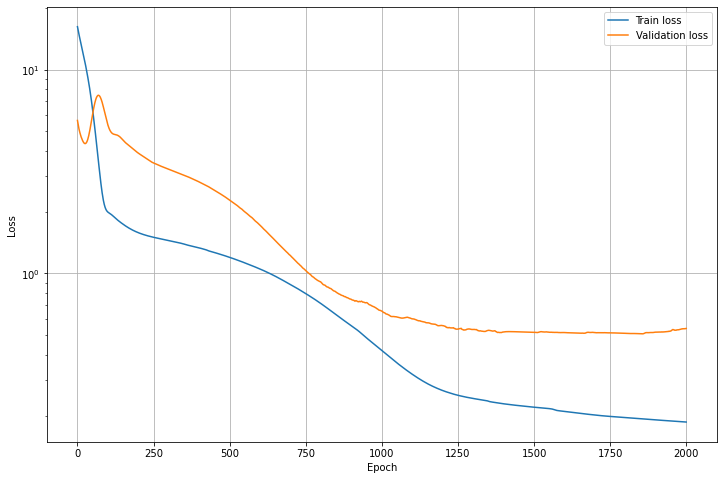

In [50]:
import datetime
save_name=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+"_"

# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig("models/"+save_name+"_Losses", dpi=400)
plt.show()

---
---
---
---
---
---
---
---

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (hand-written digit) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

Download the dataset:

In [ ]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

How to get an image and the corresponding label:

In [ ]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [ ]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

To transform a PIL Image directly to a PyTorch tensor, instead:

In [ ]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

---

**Dataset**
- Download the data in local directory
- Load the data
- Create test set
- Explore the data
- Prepare the dataset
  - Define the dataset
  - Transformations
    - Data Cleaning (not neccessary)
    - Feautre selection (not neccessary)
    - Feature Scaling ?????
  - Initialize the dataset
  - Define the dataloaders
 
 **Models**
 - Model 1: basic
 - Model 2: L2, dropout

**Training**
 - Train method
 - Test method
 
**Hyperparameters tuning:**
 - Basic with K-fold
 - grid-search with K-fold
 - Plot loss & Accuracy
 
**Test the model**
 
**Metrics summary:**
  - Loss
  - Accuracy
  - Bias & variance
  - Precision and Recall
  - F1
  - Confusion Matrix

**Network Analysis:**
  - Weights histogram
  - Analyze activations
  - Most mispredicted words